<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/02_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention

As we know, There are two sequences now: the source and the target. We use the
former to predict the latter, and they may even have different lengths.

A typical example of a sequence-to-sequence problem is translation: A sentence
goes in (a sequence of words in English), and another sentence comes out (a
sequence of words in French). This problem can be tackled using an encoderdecoder
architecture.



We’ll start by generating a synthetic dataset and then use it to
illustrate the inner workings of:

1. encoder-decoder architecture, 
2. models to predict a target sequence from a source sequence, 
3. attention mechanisms, and 
4. multi-headed attention mechanism



##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

We’ll keep drawing the same squares as before, but this time we’ll draw the first
two corners ourselves (the source sequence) and ask our model to predict the
next two corners (the target sequence).

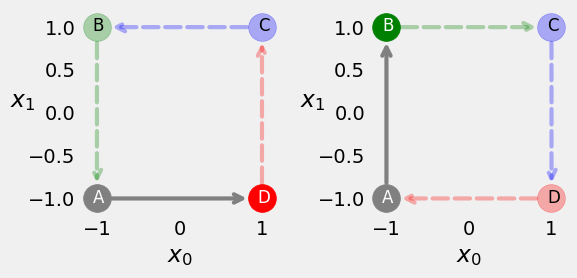

In [4]:
fig = counter_vs_clock(binary=False)

Since there are four corners to start from and two directions to follow, there are
effectively eight possible sequences (solid colors indicate the corners in the source
sequence, semi-transparent colors, the target sequence).

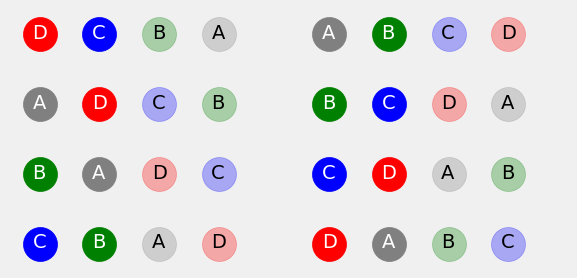

In [5]:
fig = plot_sequences(binary=False, target_len=2)

Since the desired output of our model is a sequence of coordinates (x0, x1), we’re
dealing with a regression problem now. 

Therefore, we’ll be using a typical mean
squared error loss to compare the predicted and actual coordinates for the two
points in the target sequence.

Let’s generate 256 random noisy squares.

In [6]:
points, directions = generate_sequences(n=256, seed=13)

And then let’s visualize the first five squares.

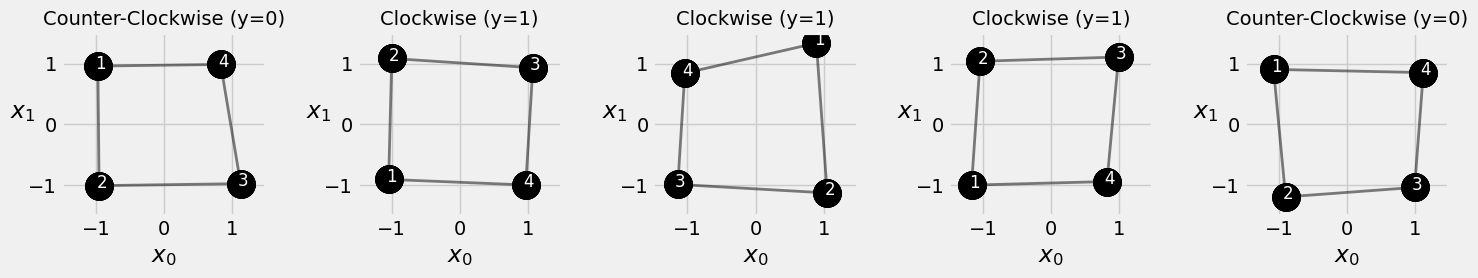

In [7]:
fig = plot_data(points, directions, n_rows=1)

##Encoder-Decoder Architecture

In order to output a sequence we need a more complex architecture.

The encoder-decoder is a combination of two models: the encoder and the
decoder.

The encoder’s goal is to generate a representation of the source
sequence; that is, to encode it.

It is a typical recurrent neural network that
we’re using to encode the source sequence.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder.png?raw=1)

The encoder model simply
returns a sequence of hidden states.

###Encoder

In [8]:
class Encoder(nn.Module):
  def __init__(self, n_features, hidden_dim):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.hidden = None
    self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

  def forward(self, X):
    rnn_out, self.hidden = self.basic_rnn(X)
    return rnn_out  # N, L, F

Don’t we need only the final hidden state?

That’s correct. We’ll be using the final hidden state only but in the "Attention", we’ll be using all hidden states, and
that’s why we’re implementing the encoder.

Let’s go over a simple example of encoding: We start with a sequence of coordinates of a "perfect" square and split it into source and target sequences:

In [9]:
full_seq = (torch.tensor([
  [-1, -1], 
  [-1, 1],
  [1, 1],
  [1, -1]
]).float().view(1, 4, 2))
full_seq

tensor([[[-1., -1.],
         [-1.,  1.],
         [ 1.,  1.],
         [ 1., -1.]]])

In [10]:
source_seq = full_seq[:, :2]  # first two corners
target_seq = full_seq[:, 2:]  # last two corners

Now, let’s encode the source sequence and take the final hidden state.

In [11]:
torch.manual_seed(21)

encoder = Encoder(n_features=2, hidden_dim=2)

# output is N, L, F
hidden_seq = encoder(source_seq)
# takes last hidden state
hidden_final = hidden_seq[:, -1:]
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

Of course, the model is untrained, so the final hidden state above is totally random.

In a trained model, however, the final hidden state will encode information about
the source sequence.



###Decoder

The decoder’s goal is to generate the target sequence from an
initial representation; that is, to decode it.

Sounds like a perfect match, doesn’t it? 

Encode the source sequence, get its
representation (final hidden state), and feed it to the decoder so it generates the
target sequence.

How does the decoder transform a hidden state into a sequence?

We can use recurrent layers for that as well.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/decoder.png?raw=1)

* In the first step, the initial hidden state is the encoder’s final hidden state ($h_f$, in blue).
* The first cell will output a new hidden state ($h_2$): That’s both the output of that cell and one of the inputs of the next cell.
* Before, we’d only run the final hidden state through a linear layer to produce the logits, but now we’ll run the output of every cell through a linear layer ($w^Th$) to convert each hidden state into predicted coordinates ($x_2$).
* The predicted coordinates are then used as one of the inputs of the second
step ($x_2$).

The first cell takes both an initial hidden state ($h_f$, in blue, the
encoder’s output) and a first data point ($x_1$, in red).

In our case, the decoder’s first data point is actually the last data point in the
source sequence because the target sequence is not a new sequence, but the
continuation of the source sequence.

This is not always the case. In translation, where the target sequence is a new sequence, the first data point is
some "special" token that indicates the start of that new sequence.

There is another small, yet fundamental difference between the
encoder and the decoder: Since the decoder uses the prediction
of last step as input to the next, we’ll have to manually loop over
the generation of the target sequence.

This also means we need to keep track of the hidden state from
last step to the next, using the hidden state of last step as input
to the next.

But, instead of making the hidden state both an input and an
output of the `forward()` method, we can easily handle this by making the hidden state an
attribute of our decoder model.




In [12]:
class Decoder(nn.Module):

  def __init__(self, n_features, hidden_dim):
    super().__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.hidden_state = None

    # Simple RNN
    self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
    # regression to produce a logits as outputs
    self.regression = nn.Linear(self.hidden_dim, self.n_features)

  def init_hidden(self, hidden_seq):
    # We only need the final hidden state
    hidden_final = hidden_seq[:, -1:]  # N, 1, H
    # Initializing decoder’s hidden state using encoder’s final hidden state. 
    self.hidden_state = hidden_final.permute(1, 0, 2) # But we need to make it sequence-first

  def forward(self, X):
    # X is batch first (N, L, F)
    # The recurrent layer both uses and updates the hidden state
    batch_first_output, self.hidden_state = self.basic_rnn(X, self.hidden_state)

    last_output = batch_first_output[:, -1:]
    out = self.regression(last_output)

    # The output has the same shape as the input (N, 1, F)
    return out.view(-1, 1, self.n_features)

So it’s time
to try some decoding to generate a target sequence:

In [13]:
torch.manual_seed(21)

decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # Predicted coordinates are next step's inputs
  inputs = outputs

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2905, 0.1976]]], grad_fn=<ViewBackward0>)



There is one problem with the approach above, though—an untrained model will
make really bad predictions, and these predictions will still be used as inputs for
subsequent steps. 

This makes model training unnecessarily hard because the
prediction error in one step is caused by both the (untrained) model and the
prediction error in the previous step.

Can’t we use the actual target sequence instead?

Sure we can! This technique is called teacher forcing.

###Teacher Forcing

The reasoning is simple: Ignore the predictions and use the real data from the
target sequence instead.

In [14]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # But completely ignores the predictions and uses real data instead
  inputs = target_seq[:, i: i + 1]  # Inputs to the next step are not predictions anymore

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2230, 0.4052]]], grad_fn=<ViewBackward0>)



This is great for training time, sure—but what about testing time,
when the target sequence is unknown?

At testing time, there is no escape from using only the model’s own predictions
from previous steps.

The problem is, a model trained using teacher forcing will minimize the loss given
the correct inputs at every step of the target sequence. But, since this will never
be the case at testing time, the model is likely to perform poorly when using its
own predictions as inputs.

What can we do about it?

During training, sometimes the model will use
teacher forcing, and sometimes it will use its own predictions. 

So we occasionally
help the model by providing an actual input, but we still force it to be robust
enough to generate and use its own inputs.

In [17]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
  print(f"Hidden: {decoder.hidden_state}")
  # Predicts coordinates
  outputs = decoder(inputs)
  print(f"Output: {outputs}\n")
  # If it is teacher forcing
  if torch.rand(1) <= teacher_forcing_prob:
    # Takes the actual element
    inputs = target_seq[:, i: i + 1]  # Inputs to the next step are not predictions anymore
  else:
    # Otherwise uses the last predicted output
    inputs = outputs

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[0.3205, 0.1144]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.8898, -0.3653]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2230, 0.4052]]], grad_fn=<ViewBackward0>)



###Encoder + Decoder

Now it is time to put the two of them together…

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_decoder.png?raw=1)

Let’s go over it once again:

* 

In [ ]:
torch.manual_seed(19)

n_features = 2
hidden_dim = 2

rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

Let’s illustrate the differences between shapes by creating a "batch" containing
three sequences, each having four data points (corners), with each data point
having two coordinates. 

Its shape is (3, 4, 2), and it is an example of a batch-first
tensor (N, L, F), like a mini-batch you’d get from a data loader:

In [ ]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

<ipython-input-23-2a03d7664898>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch = torch.as_tensor(points[:3]).float()


torch.Size([3, 4, 2])

Since RNNs use sequence-first by default, we could explicitly change the shape of
the batch using `permute()` to flip the first two dimensions:

In [ ]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

Now the data is in an "RNN-friendly" shape, and we can run it through a regular
RNN to get two sequence-first tensors back:

In [ ]:
torch.manual_seed(19)

rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
output, final_hidden = rnn(permuted_batch)
output.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

For simple RNNs, the last element of the output is the final
hidden state!

In [ ]:
(output[-1] == final_hidden).all()

tensor(True)

Once we’re done with the RNN, we can turn the data back to our familiar batchfirst
shape:

In [ ]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch.shape

torch.Size([3, 4, 2])

Alternatively, we could set the RNN’s `batch_first` argument to True so we can use the batch above without any
modifications:

In [ ]:
torch.manual_seed(19)

rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
output, final_hidden = rnn_batch_first(batch)
output.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

On the one hand, this can lead to confusion. On the other hand, most of the time we
won’t be handling the hidden state, and we’ll handle the batch-first output instead.

###Stacked RNN

First, take one RNN and feed it a sequence of data points. Next, take another RNN
and feed it the sequence of outputs produced by the first RNN. There you go—you
have a stacked RNN where each of the RNNs is considered a "layer" of the stacked
one.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacked_rnn.png?raw=1)

Each "layer" starts with its own initial hidden state and produces its own final
hidden state. The output of the stacked RNN—that is, the hidden states at each
step of the sequence—are the hidden states of the top-most layer.

Let’s create a stacked RNN with two layers.

In [ ]:
torch.manual_seed(19)

rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

Now, let’s create two simple RNNs and use the weights and biases above to set
their weights accordingly.

In [ ]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_layer0.load_state_dict(dict(list(state.items())[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1] + "0", v) for k, v in list(state.items())[:4]]))

<All keys matched successfully>

Now, let’s make a batch containing one sequence from our synthetic dataset.

In [ ]:
x = torch.as_tensor(points[0:1]).float()

In [ ]:
output_0, hidden_0 = rnn_layer0(x)

Next, it uses the sequence of hidden states as inputs for the next layer:

In [ ]:
output_1, hidden_1 = rnn_layer0(output_0)

The overall output of the stacked RNN must have two elements as well:

* A sequence of hidden states, produced by the last layer (out1).
* The concatenation of final hidden states of all layers.

In [ ]:
output_1, torch.cat([hidden_0, hidden_1])

(tensor([[[ 0.0531,  0.6414],
          [ 0.0805,  0.1358],
          [ 0.0755,  0.0951],
          [-0.4173,  0.0798]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.4173,  0.0798]]], grad_fn=<CatBackward0>))

Done! We’ve replicated the inner workings of a stacked RNN using two simple
RNNs.

You can double-check the results.

In [ ]:
output, hidden = rnn_stacked(x)
output, hidden

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<StackBackward0>))

And you’ll get exactly the same results.

For stacked RNNs, the last element of the output is the final
hidden state of the LAST LAYER! 

But, since we’re using a
batch_first layer, we need to permute the hidden state’s
dimensions to batch-first as well.

In [ ]:
(output[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

###Bidirectional RNN

First, take one RNN and feed it a sequence of data points. Next, take another RNN
and feed it the sequence of data points in reversed order. 

There you go—you’ve
got a bidirectional RNN where each of the RNNs is considered a "direction."

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/bidirect_rnn.png?raw=1)


Each "layer" starts with its own initial hidden state and produces its own final
hidden state. But, unlike the stacked version, it keeps both sequences of hidden
states produced at each step.

Why would you need a bidirectional RNN?

The reverse layer allows the network to look at
"future"
information in a given
sequence, thus better describing the context in which the elements of the
sequence exist. This is particularly important in natural language processing tasks,
where the role of a given word sometimes may only be ascertained by the word
that
follows
it. These relationships would never be captured by a unidirectional
RNN.

Let’s create a bidirectional RNN:

In [ ]:
torch.manual_seed(19)

rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

Once again, let’s create two simple RNNs, and then use the weights and biases
above to set their weights accordingly.

In [ ]:
rnn_forward = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_reverse = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_forward.load_state_dict(dict(list(state.items())[:4]))
rnn_reverse.load_state_dict(dict([(k[:-8], v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

We’ll be using the same single-sequence batch from before, but we also need it in
reverse.

In [ ]:
x_rev = torch.flip(x, dims=[1])
x_rev

tensor([[[-0.8670,  0.9342],
         [-0.8251, -0.9499],
         [ 0.8055, -0.9169],
         [ 1.0349,  0.9661]]])

Since there is no dependency between the two layers, we just need to feed each
layer its corresponding sequence (regular and reversed) and remember to reverse
back the sequence of hidden states.

In [ ]:
output, hidden = rnn_forward(x)
output_rev, hidden_rev = rnn_reverse(x_rev)

output_rev_back = torch.flip(output_rev, dims=[1])
output_rev_back

tensor([[[-0.9355, -0.8353],
         [-0.1766,  0.2596],
         [ 0.8829,  0.0425],
         [-0.2032, -0.7901]]], grad_fn=<FlipBackward0>)

The overall output of the bidirectional RNN must have two elements as well:

* A concatenation side-by-side of both sequences of hidden states
* The concatenation of the final hidden states of both layers

In [ ]:
torch.cat([output, output_rev_back], dim=2), torch.cat([hidden, hidden_rev])

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<CatBackward0>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<CatBackward0>))

Done! We’ve replicated the inner workings of a bidirectional RNN using two simple
RNNs. 

We can double-check the results.

In [ ]:
output, hidden = rnn_bidirect(x)
output, hidden

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>))

And, once again, you’ll get the very same results.


For bidirectional RNNs, the last element of the output ISN’T the
final hidden state! 

Once again, since we’re using a batch_first
layer, we need to permute the hidden state’s dimensions to batchfirst
as well:

In [ ]:
output[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

Bidirectional RNNs are different because the final hidden state
corresponds to the last element in the sequence for the forward
layer and to the first element in the sequence for the reverse
layer. 

The output, on the other hand, is aligned to sequence,
hence the difference.

##Square Model

Let’s put into practice what we’ve learned
so far and use a simple RNN to obtain the final hidden state that represents the
full sequence and use it to train a classifier layer, which is, once again, the same as
a logistic regression.

let’s simply generate new data.

In [ ]:
test_points, test_directions = generate_sequences(seed=19)

Let's do typical data preparation.

In [ ]:
train_data = TensorDataset(torch.as_tensor(points).float(), torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

The main structure behind the SquareModel is fairly simple: a simple RNN layer
followed by a linear layer that works as a classifier producing logits. 

Then, in the `forward()` method, the linear layer takes the last output of the recurrent layer as its input.

In [ ]:
class SquareModel(nn.Module):

  def __init__(self, n_features, hidden_dim, n_outputs):
    super(SquareModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.n_outputs = n_outputs
    self.hidden = None

    # Simple RNN
    self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
    # Classifier to produce as many logits as outputs
    self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

  def forward(self, X):
    # X is batch first (N, L, F)
    # output is (N, L, H)
    # final hidden state is (1, N, H)
    batch_first_output, self.hidden = self.basic_rnn(X)

    # only last item in sequence (N, 1, H)
    last_output = batch_first_output[:, -1]
    # classifier will output (N, 1, n_outputs)
    out = self.classifier(last_output)

    # final output is (N, n_outputs)
    return out.view(-1, self.n_outputs)

Next, we create an instance of the model, the corresponding loss function for a
binary classification problem, and an optimizer:

In [ ]:
torch.manual_seed(21)

model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Then, we train our SquareModel over 100 epochs.

In [ ]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

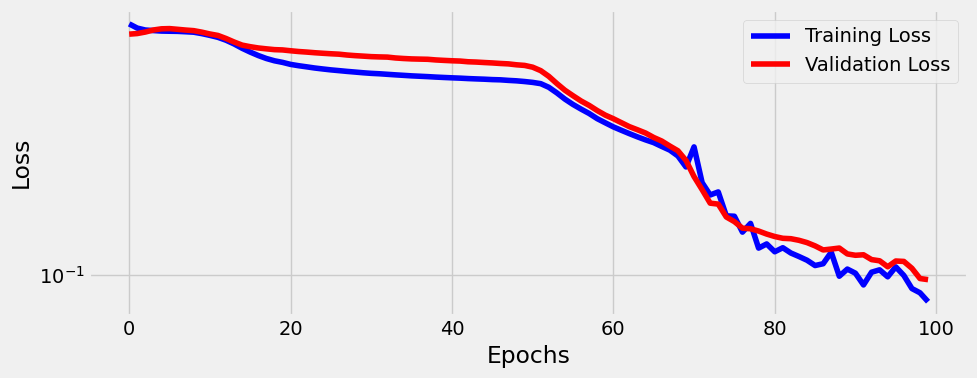

In [ ]:
fig = sbs_rnn.plot_losses()

In [ ]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

Our simple model hit 97.65% accuracy on the test data.

##Visualizing the Model

Let's explore how the model managed to
successfully classify the sequences. We’ll see the following:

* How the model transforms the inputs
* How the classifier separates the final hidden states
* What the sequence of hidden states looks like
* The journey of a hidden state through every transformation, translation, and
activation.

###Transformed Inputs

Let's see
what’s happening to the inputs (data points) before they are added up to the
transformed hidden state:

In [ ]:
state = model.basic_rnn.state_dict()
state["weight_ih_l0"], state["bias_ih_l0"]

(tensor([[-0.5201, -2.6582],
         [-1.7018, -0.4989]]),
 tensor([0.8096, 0.8822]))

Let’s visualize the transformed "perfect" square.

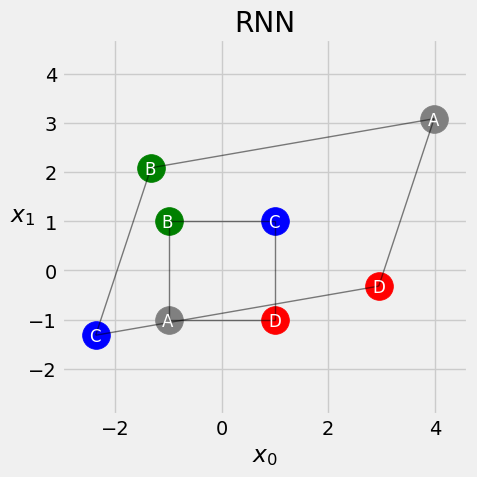

In [ ]:
fig = figure13(model.basic_rnn)

The model learned that it needs to scale, shear, flip, and translate the inputs
(corners) at every step before adding each of them to the transformed hidden
state.

###Hidden States

If we use the "perfect" square as input to our trained model, that’s what the final
hidden states look like for each of the eight sequences.

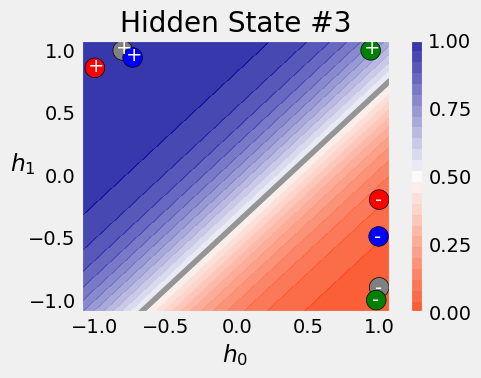

In [ ]:
fig = canonical_contour(model)

What about the other hidden states for the actual sequences?

Let’s visualize them as well.

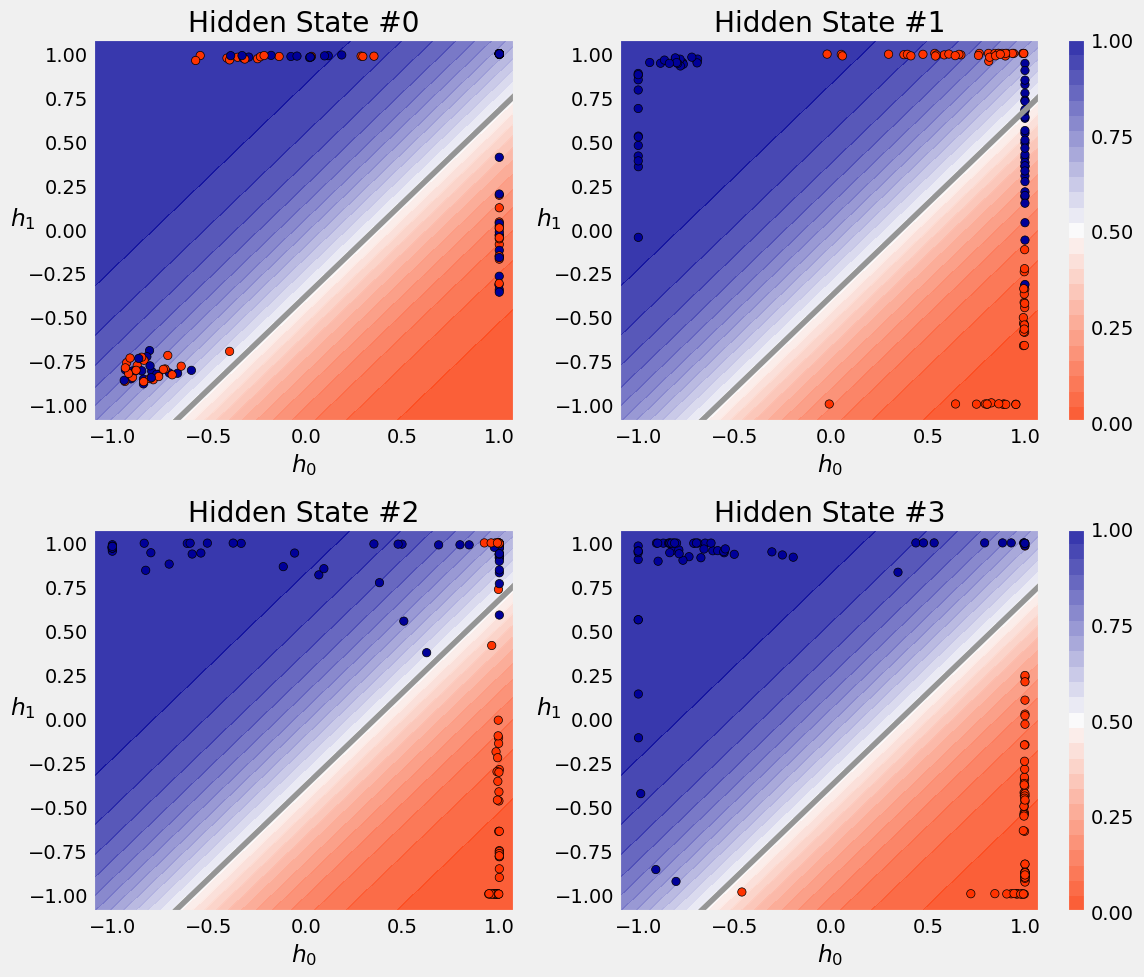

In [ ]:
fig = hidden_states_contour(model, points, directions)

###The Journey of a Hidden State

The figure below tracks the progress of the hidden state over every operation
performed inside the RNN.

The first column has the hidden state that’s an input for the RNN cell at a given
step; the second column has the transformed hidden state; the third, the
translated hidden state (by adding the transformed input); and the last, the
activated hidden state.

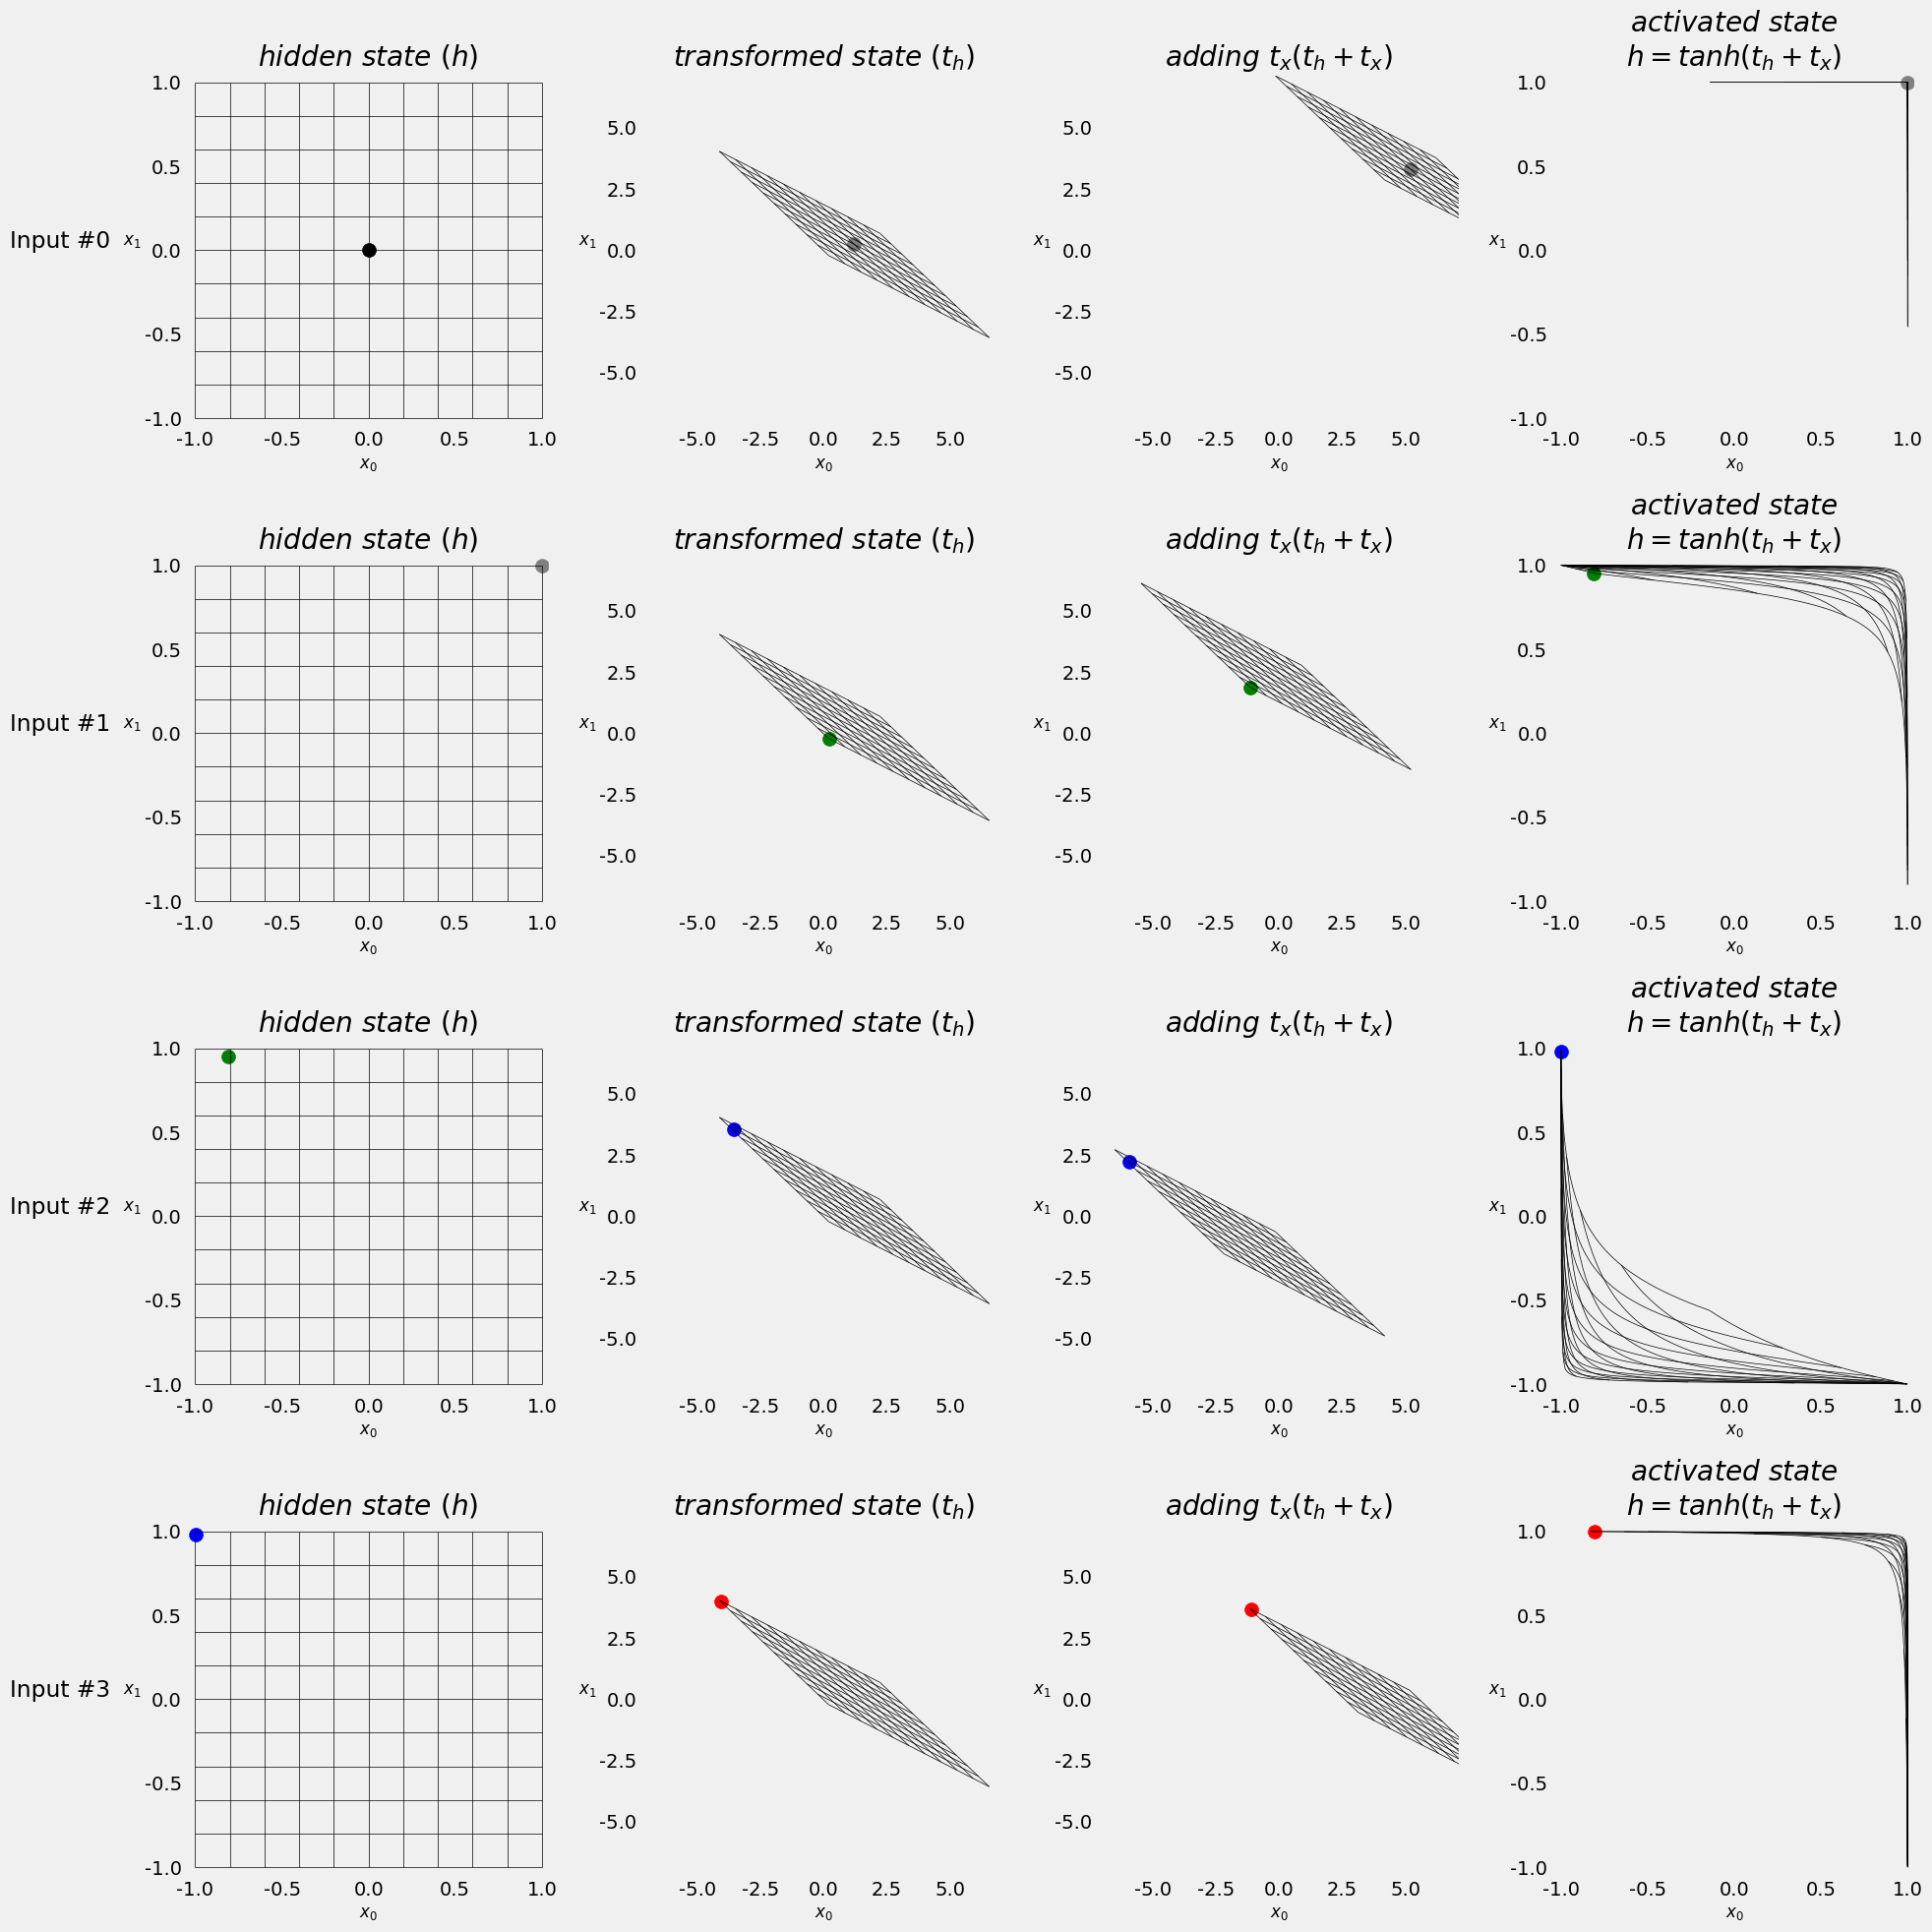

In [ ]:
fig = figure16(model.basic_rnn)

If we connect all the hidden states' positions throughout the whole sequence and
color the path following the assigned colors for each corner, we get to visualize
everything in a single plot in the end.

In [ ]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[-0.8040,  0.9987]]], grad_fn=<StackBackward0>)

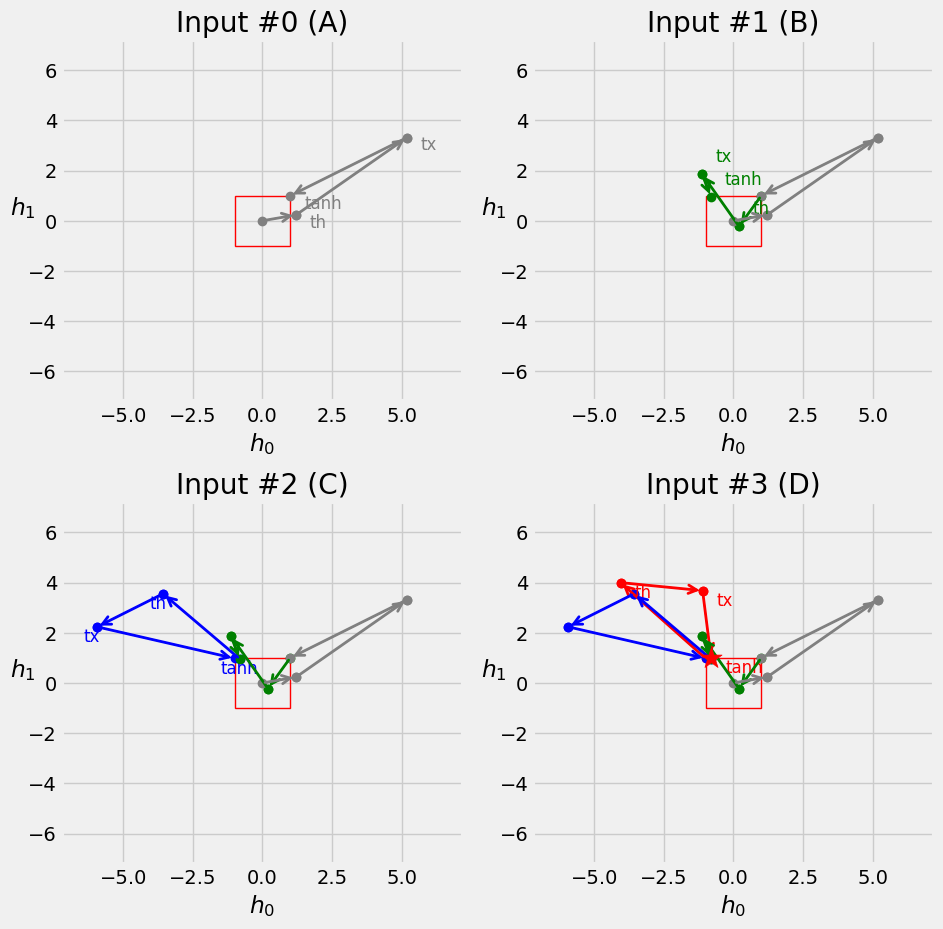

In [ ]:
fig = figure17(model.basic_rnn)

##Gated Recurrent Units (GRUs)